# An introduction to analyzing trial designs with Imprint.


We're going to analyze the Type I Error a three arm basket trial following the design of [Berry et al. (2013)](https://pubmed.ncbi.nlm.nih.gov/23983156/).

Critically, the log-odds for each arm of the trial are assumed to be drawn from a shared normal distribution. This hierarchical design leads to a sharing effect between the log-odds for the different arms.

\begin{align}
\mathbf{y} &\sim \mathrm{Binomial}( \mathbf{p}, \mathbf{n})\\
\mathbf{p} &= \mathrm{expit}(\mathbf{\theta} + logit(\mathbf{p_1}))\\
\mathbf{\theta} &\sim N(\mu, \sigma^2)\\
\mu &\sim N(\mu_0, S^2)\\
\sigma^2 &\sim \mathrm{InvGamma}(0.0005, 0.000005)\\
\end{align}


## Part 0: Type I Error

In [ ]:
from scipy.special import logit
import matplotlib.pyplot as plt
import numpy as np

import imprint as ip
import model

# This is the binomial n parameter, the number of patients recruited to each arm of the trial.
n_arm_samples = 35

In [2]:
g = ip.cartesian_grid(
    theta_min=[-3.5, -3.5, -3.5],
    theta_max=[1.0, 1.0, 1.0],
    n=[16, 16, 16],
    null_hypos=[ip.hypo(f"theta{i} < {logit(0.1)}") for i in range(3)],
)
validation_df = ip.validate(
    model.BayesianBasket,
    g,
    0.05,
    K=2000,
    model_kwargs={"n_arm_samples": n_arm_samples},
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


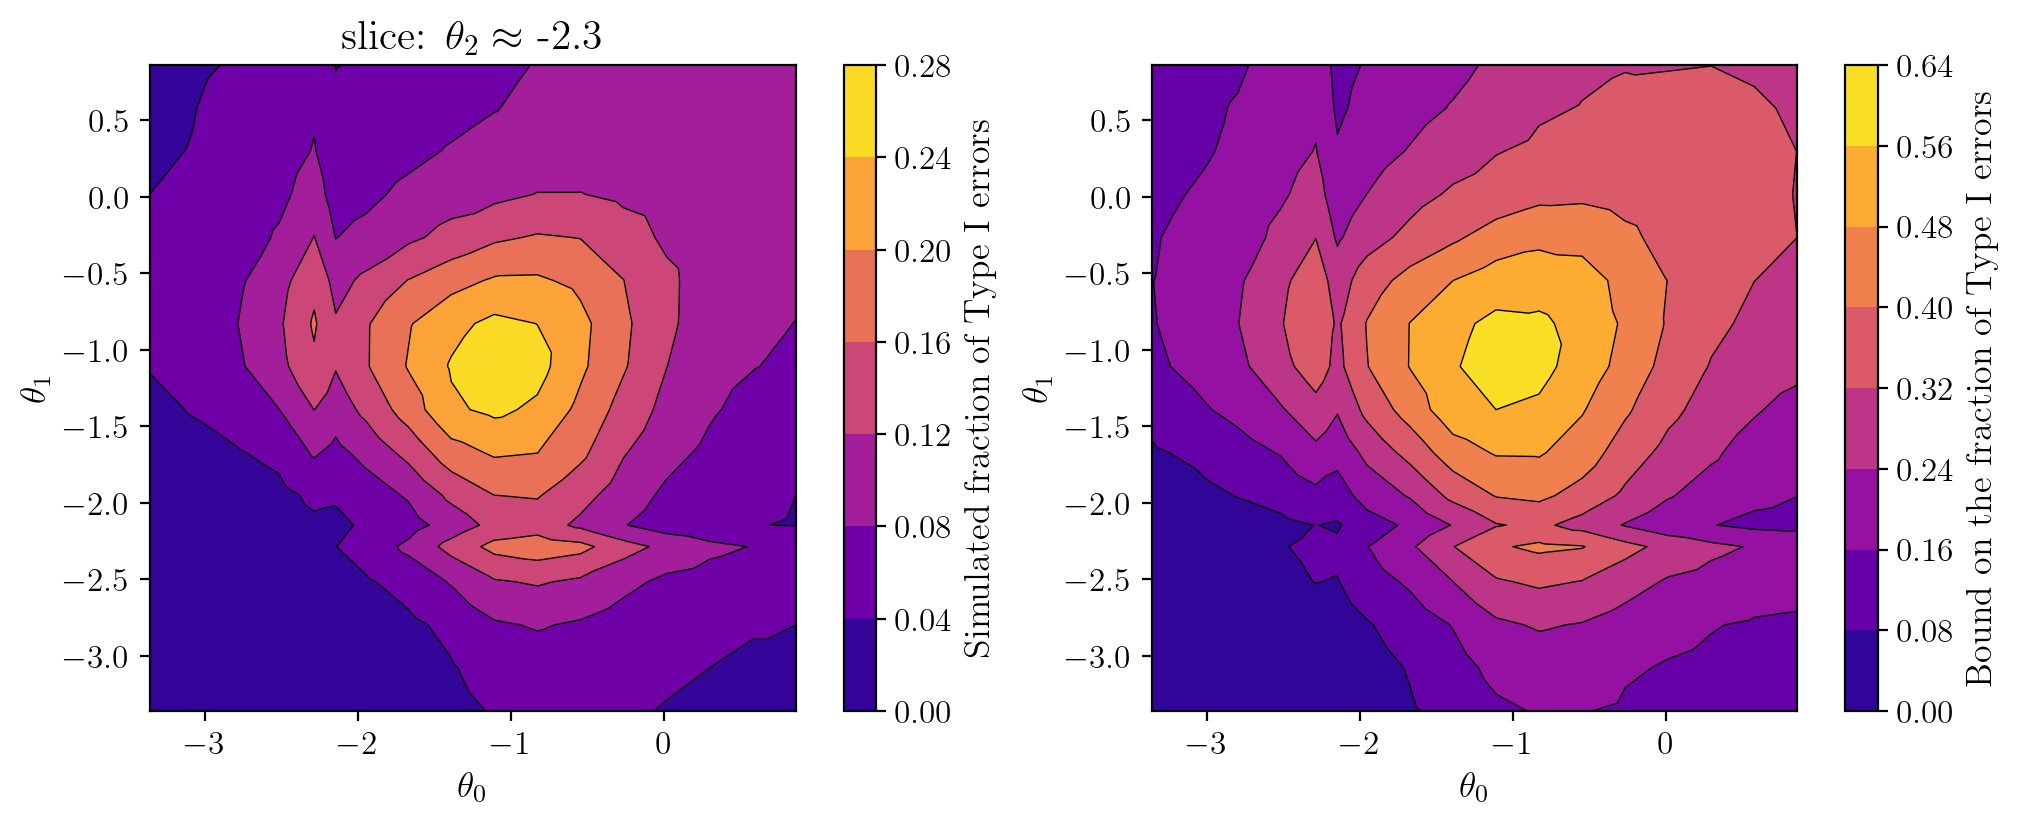

In [69]:
ip.setup_nb()
plt.figure(figsize=(10, 4), constrained_layout=True)
theta_tiles = g.get_theta()
t2 = np.unique(theta_tiles[:, 2])[4]
selection = theta_tiles[:, 2] == t2

plt.subplot(1, 2, 1)
plt.title(f"slice: $\\theta_2 \\approx$ {t2:.1f}")
cntf = plt.tricontourf(
    theta_tiles[selection, 0],
    theta_tiles[selection, 1],
    validation_df["tie_est"][selection],
)
plt.tricontour(
    theta_tiles[selection, 0],
    theta_tiles[selection, 1],
    validation_df["tie_est"][selection],
    colors="k",
    linestyles="-",
    linewidths=0.5,
)
cbar = plt.colorbar(cntf)
cbar.set_label("Simulated fraction of Type I errors")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.axis("square")

plt.subplot(1, 2, 2)
cntf = plt.tricontourf(
    theta_tiles[selection, 0],
    theta_tiles[selection, 1],
    validation_df["tie_bound"][selection],
)
plt.tricontour(
    theta_tiles[selection, 0],
    theta_tiles[selection, 1],
    validation_df["tie_bound"][selection],
    colors="k",
    linestyles="-",
    linewidths=0.5,
)
cbar = plt.colorbar(cntf)
cbar.set_label("Bound on the fraction of Type I errors")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.axis("square")

plt.show()

## Part 1: Constructing a parameter grid

We're going to use the `grid.make_cartesian_gridpts` function to produce a 3 dimensional set of points covering $\theta_i \in [-3.5, 1.0]$. The points lie at the center of (hyper)rectangular cells. The cells cover the whole box.


In [5]:
g_raw = ip.cartesian_grid(
    theta_min=[-3.5, -3.5, -3.5], theta_max=[1.0, 1.0, 1.0], n=[16, 16, 16]
)
type(g_raw)

In [7]:
g_raw.df.head()

,id,active,parent_id,theta0,theta1,theta2,radii0,radii1,radii2
0,4159720287677710336,True,0,-3.359375,-3.359375,-3.359375,0.140625,0.140625,0.140625
1,4159720287677710337,True,0,-3.359375,-3.359375,-3.078125,0.140625,0.140625,0.140625
2,4159720287677710338,True,0,-3.359375,-3.359375,-2.796875,0.140625,0.140625,0.140625
3,4159720287677710339,True,0,-3.359375,-3.359375,-2.515625,0.140625,0.140625,0.140625
4,4159720287677710340,True,0,-3.359375,-3.359375,-2.234375,0.140625,0.140625,0.140625


Next, we need to define the null hypothesis space. There are built-in tools in imprint for translating a symbolic statement to a bounding plane for a null hypothesis space.

Once we have defined these planes, we attach the null hypothesis to the grid created above using `Grid.add_null_hypos`. For each hyperrectangular cell, the method intersects with the null hypothesis boundaries and splits into multiple tiles whenever a cell is intersected by a null hypothesis plane.


In [8]:
logit(0.1)

-2.197224577336219

In [9]:
null_hypos = [
    ip.hypo(f"theta0 < -2.1972"),
    ip.hypo(f"theta1 < -2.1972"),
    ip.hypo(f"theta2 < -2.1972"),
]
g_unpruned = g_raw.add_null_hypos(null_hypos)

In [10]:
g_unpruned.df.head()

,id,active,parent_id,theta0,theta1,theta2,radii0,radii1,radii2,null_truth0,null_truth1,null_truth2
0,4159720287677710336,True,0,-3.359375,-3.359375,-3.359375,0.140625,0.140625,0.140625,True,True,True
1,4159720287677710337,True,0,-3.359375,-3.359375,-3.078125,0.140625,0.140625,0.140625,True,True,True
2,4159720287677710338,True,0,-3.359375,-3.359375,-2.796875,0.140625,0.140625,0.140625,True,True,True
3,4159720287677710339,True,0,-3.359375,-3.359375,-2.515625,0.140625,0.140625,0.140625,True,True,True
4,4159720287677710340,False,0,-3.359375,-3.359375,-2.234375,0.140625,0.140625,0.140625,True,True,True


Next, we can optionally prune our grid by calling `Grid.prune(g)`. Pruning will remove any tiles that are entirely in the alternative hypothesis space for all arms. Since our goal is to calculate type I error, we do not care about the alternative hypothesis space. For a false positive to occur, the truth must be negative!


In [11]:
g = g_unpruned.prune()

In [12]:
g_unpruned.n_tiles, g.n_tiles

(5730, 4002)

In [13]:
g = ip.cartesian_grid(
    theta_min=[-3.5, -3.5, -3.5],
    theta_max=[1.0, 1.0, 1.0],
    n=[16, 16, 16],
    null_hypos=[ip.hypo(f"theta{i} < {logit(0.1)}") for i in range(3)],
)

**At this point, you can skip to the next section if you're not interested in learning about the details of the grid object.**

Here, we'll grab a few of the important variables from the grid object and examine them. First, let's look at the center of each tile in the grid. The shape of the array will be `(n_tiles, 3)` because we have 3 parameter values per point.


In [14]:
theta_tiles = g.get_theta()
theta_tiles.shape

(4002, 3)

In [15]:
unique_t2 = np.unique(theta_tiles[:, 2])
unique_t2

array([-3.359375  , -3.078125  , -2.796875  , -2.515625  , -2.28611229, -2.234375  , -2.14548729,
       -1.953125  , -1.671875  , -1.390625  , -1.109375  , -0.828125  , -0.546875  , -0.265625  ,
        0.015625  ,  0.296875  ,  0.578125  ,  0.859375  ])

In the figure below, we plot $\theta_0$ and $\theta_1$ for a couple different values of $\theta_2$. You can see that the shape of the domain in $(\theta_0, \theta_1)$ changes depending on whether $\theta_2$ is in the null space for arm 2 or not. The solid white region without any tile centers in the right figure represents the region where the alternative hypothesis is true for all three arms. The solid black lines represent the boundaries of the arm 0 and the arm 1 null hypothesis boundary planes.


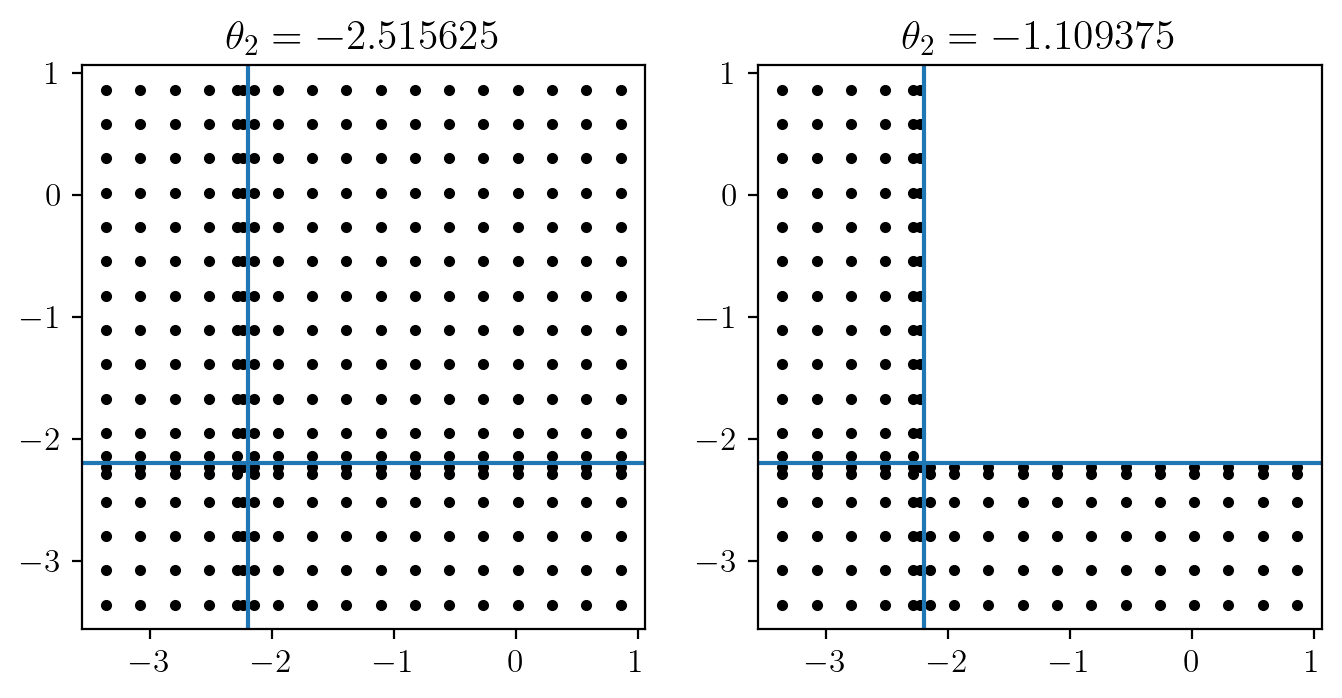

In [65]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.title(f"$\\theta_2 = {unique_t2[3]}$")
selection = theta_tiles[:, 2] == unique_t2[3]
plt.plot(theta_tiles[selection, 0], theta_tiles[selection, 1], "k.")
plt.hlines(logit(0.1), -4, 2)
plt.vlines(logit(0.1), -4, 2)
plt.axis("square")
plt.xlim(np.min(theta_tiles[:, 0]) - 0.2, np.max(theta_tiles[:, 0]) + 0.2)
plt.ylim(np.min(theta_tiles[:, 1]) - 0.2, np.max(theta_tiles[:, 1]) + 0.2)

plt.subplot(1, 2, 2)
plt.title(f"$\\theta_2 = {unique_t2[10]}$")
selection = theta_tiles[:, 2] == unique_t2[10]
plt.plot(theta_tiles[selection, 0], theta_tiles[selection, 1], "k.")
plt.hlines(logit(0.1), -4, 2)
plt.vlines(logit(0.1), -4, 2)
plt.axis("square")
plt.xlim(np.min(theta_tiles[:, 0]) - 0.2, np.max(theta_tiles[:, 0]) + 0.2)
plt.ylim(np.min(theta_tiles[:, 1]) - 0.2, np.max(theta_tiles[:, 1]) + 0.2)
plt.show()

Let's explore another useful array produced for the grid. The `g.null_truth` array will contain whether the null hypothesis is true for each arm for each tile. Naturally, this has the same shape as `theta_tiles`.


In [17]:
g.get_null_truth().shape

(4002, 3)

Since we've pruned the grid, the tiles are all in the null hypothesis space for at least one arm.


In [18]:
np.all(np.any(g.get_null_truth(), axis=1))

True

## Part 2: Simulating to compute type I error rates and gradients


Now that we've constructed and examined our computation grid, let's actually compute type I error and its gradient.

First, in order to do this, we need to build an inference algorithm that tells us whether to reject or not given a particular dataset. We're going to use an implementation of INLA applied to the model described above. The `fi.rejection_inference` function below will implement this inference algorithm. The details of this inference are not particularly important to what we're doing here so we'll leave it unexplained. Please check out the [intro_to_inla.ipynb](./intro_to_inla.ipynb) notebook if you're interested in learning more.

First, we'll check that the inference does something reasonable. It rejects the null for arms 1 and 2 where the success counts are 5 and 9 but does not reject the null for arm 0 where the success count is 4. This seems reasonable!


In [46]:
y = [[4, 5, 9]]
n = [[35, 35, 35]]
fi = basket.FastINLA(n_arms=3, critical_value=0.95)
fi.rejection_inference(np.stack((y, n), axis=-1))

DeviceArray([[False,  True,  True]], dtype=bool)

In [47]:
import jax
import jax.numpy as jnp


class BayesianBasket:
    def __init__(self, seed, K):
        np.random.seed(seed)
        self.samples = np.random.uniform(size=(K, n_arm_samples, 3))
        self.fi = basket.FastINLA(n_arms=3)
        self.family = "binomial"
        self.family_params = {"n": n_arm_samples}

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        # 1. Calculate the binomial count data.
        # The sufficient statistic for binomial is just the number of uniform draws
        # above the threshold probability. But the `p_tiles` array has shape (n_tiles,
        # n_arms). So, we add empty dimensions to broadcast and then sum across
        # n_arm_samples to produce an output `y` array of shape: (n_tiles,
        # sim_size, n_arms)

        p = jax.scipy.special.expit(theta)
        y = jnp.sum(self.samples[None] < p[:, None, None], axis=2)

        # 2. Determine if we rejected each simulated sample.
        # rejection_fnc expects inputs of shape (n, n_arms) so we must flatten
        # our 3D arrays. We reshape exceedance afterwards to bring it back to 3D
        # (n_tiles, sim_size, n_arms)
        y_flat = y.reshape((-1, 3))
        n_flat = jnp.full_like(y_flat, n_arm_samples)
        data = jnp.stack((y_flat, n_flat), axis=-1)
        test_stat_per_arm = self.fi.test_inference(data).reshape(y.shape)

        return jnp.min(
            jnp.where(null_truth[:, None, :], test_stat_per_arm, jnp.inf), axis=-1
        )

In [48]:
sims = BayesianBasket(0, 100).sim_batch(0, 100, theta_tiles, g.get_null_truth())

In [49]:
rejections = sims < 0.05
n_rejections = np.sum(rejections, axis=1)

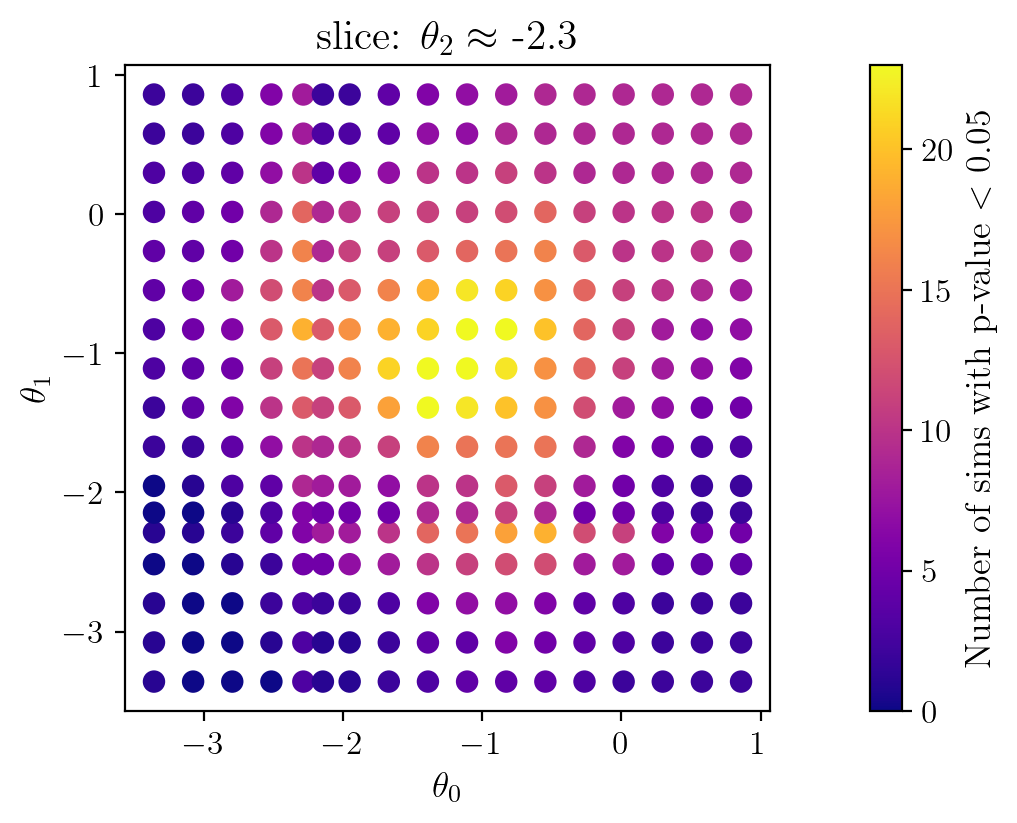

In [72]:
plt.figure(figsize=(5, 4), constrained_layout=True)
select = theta_tiles[:, 2] == np.unique(theta_tiles[:, 2])[4]
plt.scatter(
    theta_tiles[select, 0], theta_tiles[select, 1], c=n_rejections[select], s=50
)
cbar = plt.colorbar()
cbar.set_label(r"Number of sims with p-value $<$ 0.05")
plt.title(f"slice: $\\theta_2 \\approx$ {t2:.1f}")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.axis("square")
plt.show()

In [51]:
%%time
validation_df = ip.validate(BayesianBasket, g, 0.05, K=2000)

CPU times: user 1min 43s, sys: 5.19 s, total: 1min 48s
Wall time: 37.9 s


In [73]:
validation_df.head()

,tie_sum,tie_est,tie_cp_bound,tie_bound
0,0,0.0000,0.002300,0.006915
1,0,0.0000,0.002300,0.007188
2,1,0.0005,0.003315,0.010373
3,5,0.0025,0.006541,0.019714
4,19,0.0095,0.015872,0.044396


Next, the meat of the type I error calculation will be done by `binomial_accumulator`. This is a JAX function that will just in time compile into a very fast compiled version when passed a function that implements the rejection inference. Then, we call the JIT function `accumulator` and pass it the necessary information:

- the array of tile centers
- the truth value of each hypothesis for each tile.
- the simulated data.

Internally, this function will simulate `sim_size` trials for each tile and return:

- `typeI_sum`: the number of simulations during which any arm had a false rejections (family-wise error).
- `typeI_score`: the score/gradient of the typeI_sum output with respect to the true parameter values.

Here, we are running 2000 simulations for each of 3185 tiles.


Before continuing, let's look at a couple slices of this type I error grid:


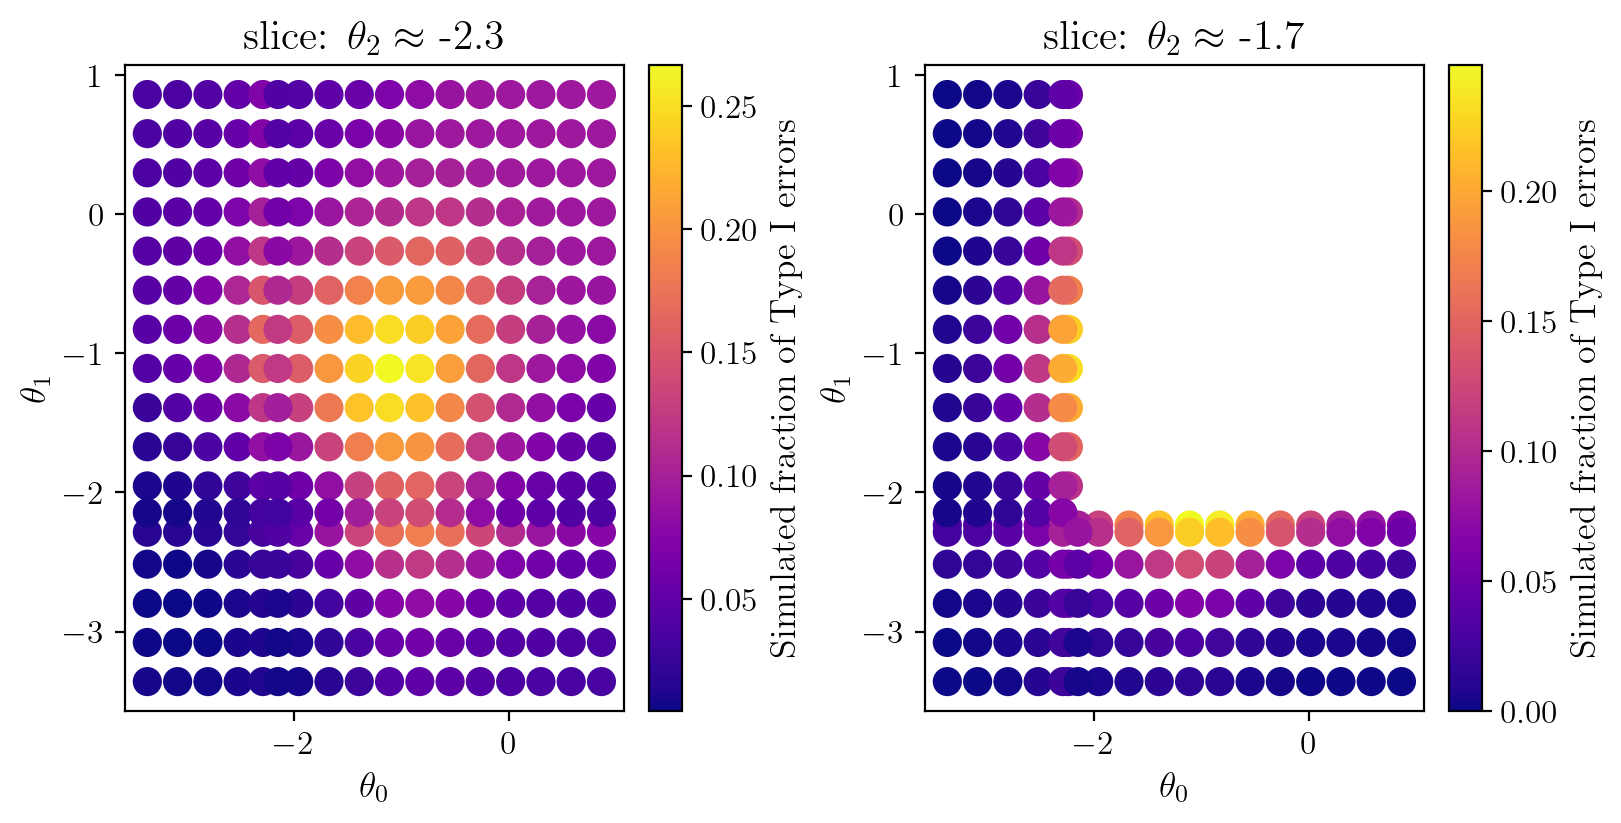

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4), constrained_layout=True)
for i, t2_idx in enumerate([4, 8]):
    t2 = np.unique(theta_tiles[:, 2])[t2_idx]
    selection = theta_tiles[:, 2] == t2

    plt.subplot(1, 2, i + 1)
    plt.title(f"slice: $\\theta_2 \\approx$ {t2:.1f}")
    plt.scatter(
        theta_tiles[selection, 0],
        theta_tiles[selection, 1],
        c=validation_df["tie_est"][selection],
        s=90,
    )
    cbar = plt.colorbar()
    plt.xlabel(r"$\theta_0$")
    plt.ylabel(r"$\theta_1$")
    cbar.set_label("Simulated fraction of Type I errors")
plt.show()

Note that the upper bound here is going to be quite loose because we have a very coarse grid. The looseness of the bound will be quadratic in cell size because of the second order term. In addition, there is a lot of error in our pointwise type I error estimate because the number of simulations is only 2000.


## Step 4: 3D Bound visualization


For this last step, we're going to visualize the bound with a Plotly 3D visualization tool.

In [80]:
bound_components = np.array(
    [
        validation_df["tie_est"],
        validation_df["tie_cp_bound"] - validation_df["tie_est"],
        validation_df["tie_bound"] - validation_df["tie_cp_bound"],
        validation_df["tie_bound"],
    ]
).T
t2 = np.unique(theta_tiles[:, 2])[4]
selection = theta_tiles[:, 2] == t2

np.savetxt("P_tutorial.csv", theta_tiles[selection, :].T, fmt="%s", delimiter=",")
np.savetxt("B_tutorial.csv", bound_components[selection, :], fmt="%s", delimiter=",")

Open [the frontend installation instructions](../../frontend/README.md) and follow them. Copied here:

1. On Mac: `brew install node`. Elsewhere, figure out how to install nodejs!
2. Install reactjs with `npm i react-scripts`

Finally:

```bash
cd frontend
npm start
```

You should see something that looks like:

<img src="bound_viz_example.png" alt="" width="400"/>

Click on "Upload B matrix" and choose the B matrix we just saved. Do the same for the P matrix. Now you should be able to play around with the 3D visualization! Also, you can select the different layers to see the magnitude of different bound components.
